In [119]:
import matplotlib.pyplot as plt
from pylab import rcParams

In [120]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [121]:
import mne

In [122]:
import pandas as pd

In [123]:
from scipy.io import loadmat

In [124]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [161]:
subject = "S5"

In [162]:
session = loadmat('data/{}.mat'.format(subject))

In [163]:
session

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Jun 25 11:26:40 2020',
 '__version__': '1.0',
 'fs': array([[250]], dtype=uint8),
 'trig': array([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], dtype=int16),
 'y': array([[ -7.30613625,   1.3315682 , -10.83861505, ...,  -4.27406039,
           1.30017107,   6.11832613],
        [ -8.48543913,   1.73635348,  -7.95181543, ...,  -1.67533302,
           2.46804612,   7.07319667],
        [ -9.7031921 ,   1.60667916,  -4.40113701, ...,   3.08787224,
           3.56190653,   7.76033321],
        ...,
        [ 25.7026211 ,  -6.42408369,   1.68372238, ...,  18.96521821,
         -12.49643695,  -0.15902938],
        [ 26.35654495,  -5.34583461,   3.29601472, ...,  18.39830268,
         -10.26110472,  -0.10157686],
        [ 26.37334077,  -4.94438258,   4.37500684, ...,  17.90661394,
          -8.56603912,   0.06784526]])}

In [164]:
channels = ["Fz", "Cz", "P3", "Pz", "P4", "Po7", "Po8", "Oz"]

In [165]:
session_df = pd.DataFrame(session["y"], columns=channels)

In [166]:
sfreq = session["fs"][0][0]

In [167]:
session_df["Time"] = session_df.index / session["fs"][0][0]

In [168]:
session_df["Trigger"] = session["trig"]
session_df.loc[session_df["Trigger"] == -1, "Trigger"] = 2

# Restore raw

In [169]:
channels += ['Trigger']

In [170]:
info = mne.create_info(ch_names=channels, sfreq=sfreq)

In [171]:
raw = mne.io.RawArray(session_df[channels].values.T, info)

Creating RawArray with float64 data, n_channels=9, n_times=60855
    Range : 0 ... 60854 =      0.000 ...   243.416 secs
Ready.


In [172]:
channel_types = {c: 'eeg' for c in channels}
channel_types['Trigger'] = 'stim'

In [173]:
raw.set_channel_types(channel_types)

The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.


<ipython-input-173-656cff14ccc4>:1: RuntimeWarning: The unit for channel(s) Cz, Fz, Oz, P3, P4, Po7, Po8, Pz has changed from NA to V.
  raw.set_channel_types(channel_types)


# Pipeline

In [174]:
def plot_raw(raw, start=0, stop=240):
    rcParams['figure.figsize'] = 20, 10
    mne.viz.plot_raw(
        raw, 
        start=start, 
        duration=stop - start, 
        show=False, 
        n_channels=8,
        scalings={'eeg': 100}
    )
    plt.show()

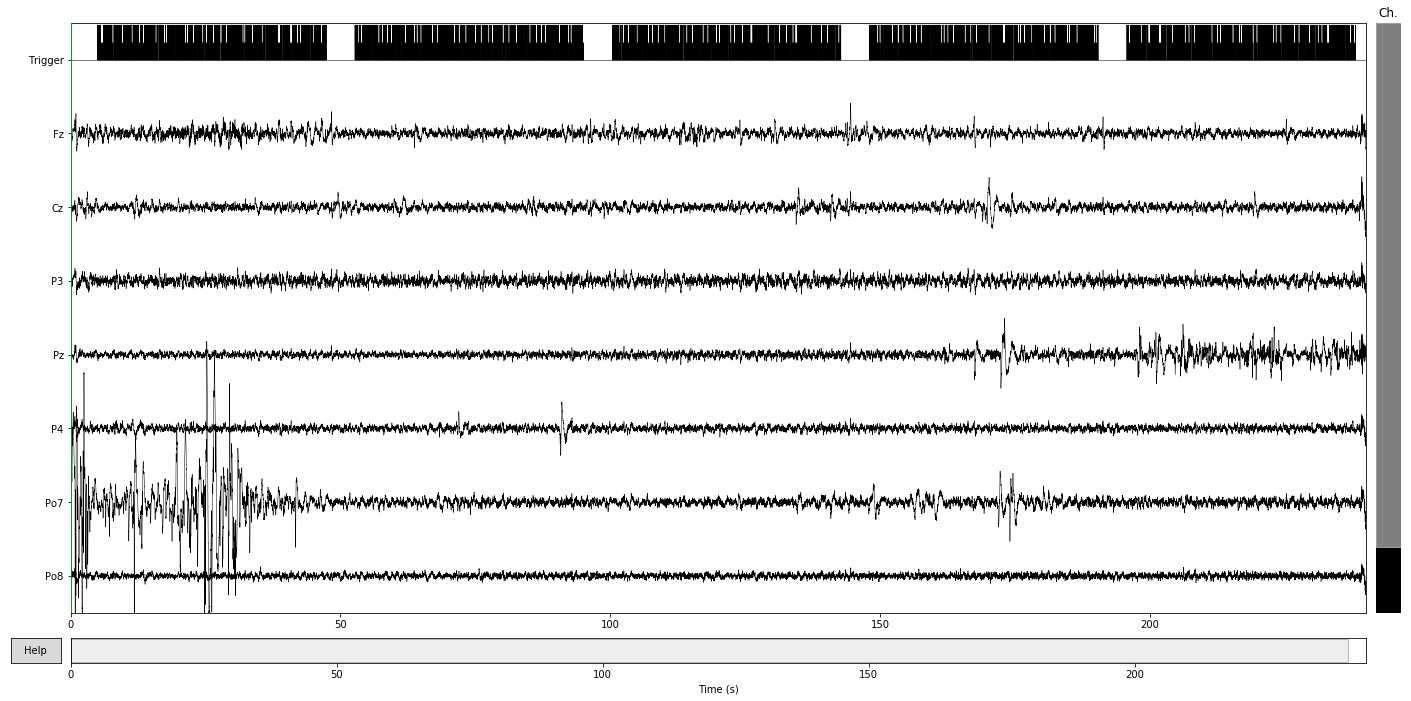

In [175]:
plot_raw(raw)

In [176]:
raw.notch_filter(50)

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1651 samples (6.604 sec) selected


<RawArray  |  None, n_channels x n_times : 9 x 60855 (243.4 sec), ~4.2 MB, data loaded>

In [177]:
raw.filter(0.5, 30)

Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1651 samples (6.604 sec) selected


<RawArray  |  None, n_channels x n_times : 9 x 60855 (243.4 sec), ~4.2 MB, data loaded>

Other kind of filtering - when the amplitude > a + std, then mark epoch as bad

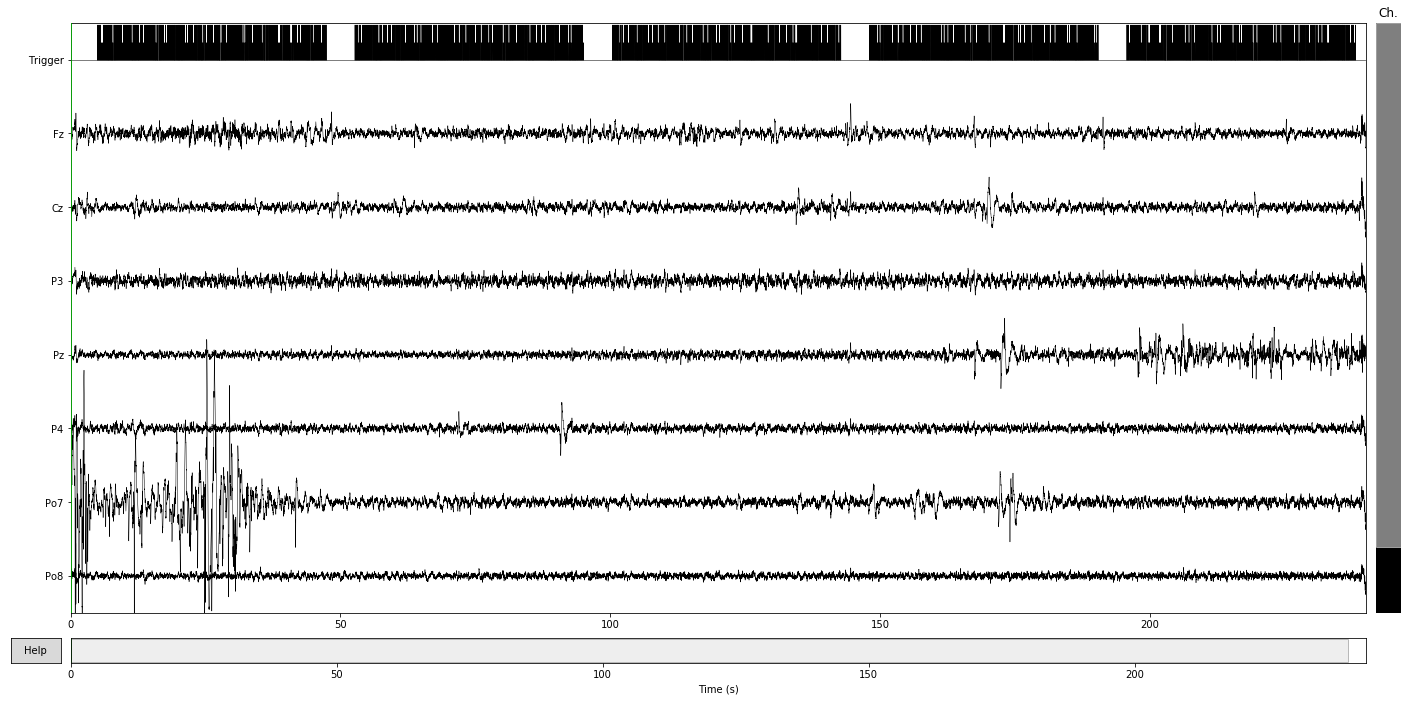

In [178]:
plot_raw(raw)

In [179]:
events = mne.find_events(raw, 'Trigger')

1200 events found
Event IDs: [1 2]


In [180]:
ica = mne.preprocessing.ICA()

In [181]:
ica.fit(raw)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 8
Fitting ICA took 0.4s.


<ICA  |  raw data decomposition, fit (fastica): 60855 samples, 8 components, channels used: "eeg">

In [182]:
ica_eeg = ica.get_sources(raw)

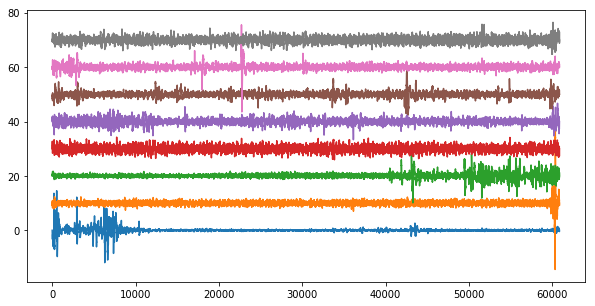

In [183]:
plt.figure(figsize=(10, 5))
plt.plot(ica_eeg[:, :][0].T + 10 * np.arange(0, 8))

In [184]:
stds = np.std(np.abs(ica_eeg[:, :][0]), axis=1)
exclude_components = (-stds).argsort()[0:2]

In [185]:
raw = ica.apply(raw.copy(), exclude=list(exclude_components))

Transforming to ICA space (8 components)
Zeroing out 2 ICA components


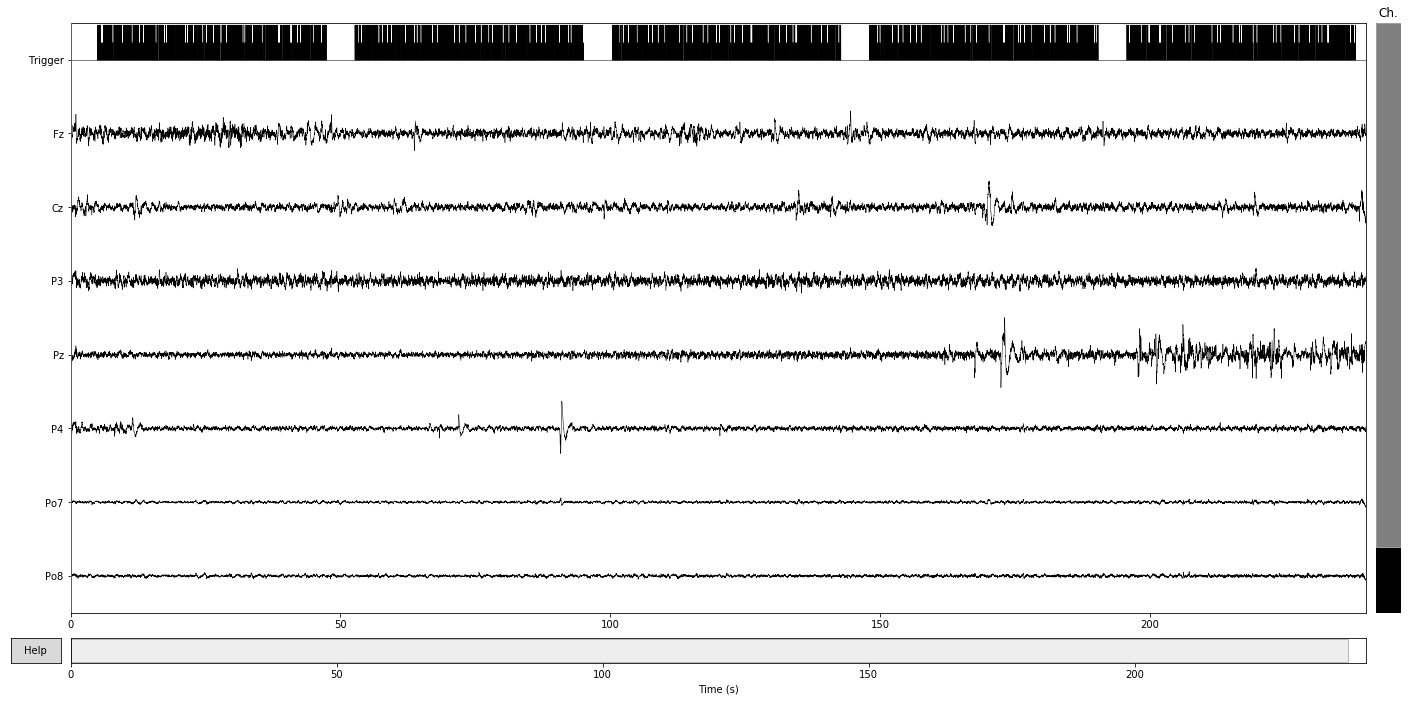

In [186]:
plot_raw(raw)

In [187]:
def get_epochs(raw):
    global events
    epochs = mne.Epochs(
        raw.pick_types(eeg=True), 
        events, tmin=-0.1, tmax=0.7,
        reject_by_annotation=False,
        preload=True
    )
#     epochs = epochs.apply_baseline((-0.1, 0))
    return epochs.decimate(12)

In [188]:
epochs = get_epochs(raw)

1200 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1200 events and 201 original time points ...
0 bad epochs dropped
The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.


<ipython-input-187-298b03c8cc96>:10: RuntimeWarning: The measurement information indicates a low-pass frequency of 30 Hz. The decim=12 parameter will result in a sampling frequency of 20.8333 Hz, which can cause aliasing artifacts.
  return epochs.decimate(12)


time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-189-6483dd0a9efd>:1: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['1'].average().plot()


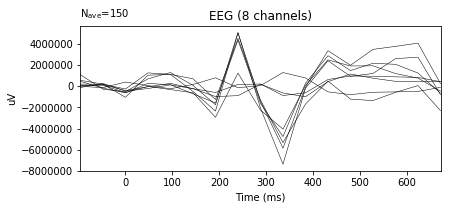

In [189]:
epochs['1'].average().plot()
plt.show()

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-190-cbc117c68eed>:1: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs['2'].average().plot()


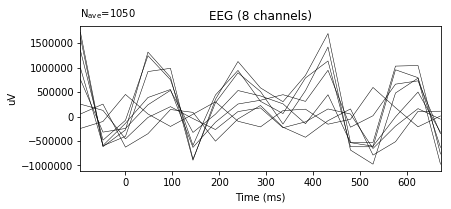

In [190]:
epochs['2'].average().plot()
plt.show()

In [191]:
epochs.event_id

{'1': 1, '2': 2}

In [192]:
true_events = epochs['1'].get_data()

In [193]:
false_events = epochs['2'].get_data()

In [194]:
y = [1] * true_events.shape[0] + [0] * false_events.shape[0]

In [195]:
X = np.vstack([true_events, false_events]).reshape(len(y), -1)

In [196]:
all_X += [X]
all_y += y
all_subjects += [subject] * X.shape[0]

# All features

In [43]:
all_X = []

In [44]:
all_y = []

In [45]:
all_subjects = []

In [197]:
merged_X = np.vstack(all_X)
merged_y = np.array(all_y)

In [198]:
merged_X.shape

(6000, 136)

In [199]:
merged_y.shape

(6000,)

In [200]:
lda_features_df = pd.DataFrame(merged_X, columns=["f{}".format(i) for i in range(merged_X.shape[1])])

In [201]:
lda_features_df["y"] = merged_y

In [202]:
lda_features_df["s"] = all_subjects

In [203]:
lda_features_df.to_csv("lda-power.csv", index=False)

Here is a description of LDA pipeline from the paper above:
- power-based artifact rejection
- band-pass 0.5-30Hz
- decimation by a factor of 12
- whitening
- trials extraction, from -100ms to 700ms, for each stimulus
- 120-dimensional LDA
- 200 repetitions of randomized cross-validation